In [296]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn import metrics

import wandb
from wandb.keras import WandbCallback

#custom packages
from config import setup_wandb_dedicated, setup_wandb_parametrized
from models import MyModel, createSimpleModel

In [206]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [41]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [61]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [62]:
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [63]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [64]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

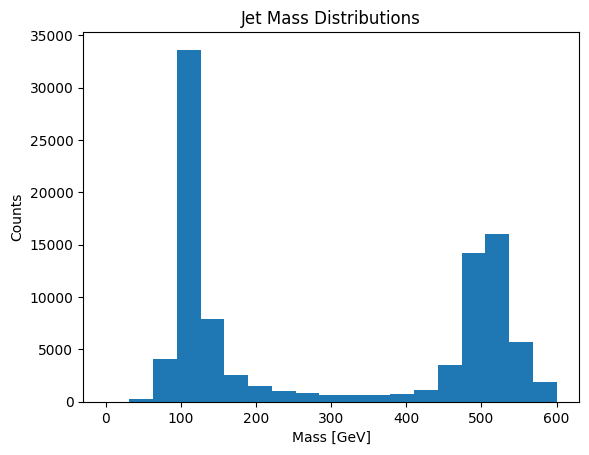

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [10]:
file = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq.txt")

jets = []
count = 0
for line in file:
    if count == 2:
        break
    print(line)
    jets += [line.split("J")[1].split("P")[0].split()]
    count+=1

0 0 J 1788.55 -0.300279 -2.51608 130.279 0 0.0289343 0.0153102 0.0126833 0.010346 0.00825964  P 4.64413 -0.377384 3.00207  P 2.47947 -0.425799 3.02334  P 2.68613 -0.39458 -2.608  P 5.84707 -0.404504 -2.54133  P 24.9416 -0.408844 -2.52053  P 6.58412 -0.387347 -2.54543  P 13.1517 -0.350432 -2.59254  P 13.7381 -0.300859 -2.52212  P 4.55674 -0.286343 -2.52545  P 517.142 -0.286492 -2.50205 

0 1 J 1643.32 -0.173344 0.717105 95.8961 0 0.0424313 0.0221081 0.0140335 0.0108518 0.00877299  P 1.75001 -0.530883 0.585762  P 2.74298 -0.297844 0.694373  P 5.4756 -0.195946 0.630677  P 7.35714 -0.200437 0.647468  P 9.16487 -0.119969 0.704896  P 5.77878 -0.125155 0.709119  P 6.37682 -0.141306 0.773328  P 8.23397 -0.155549 0.732862  P 29.6409 -0.186092 0.763671  P 2.24246 -0.170876 0.729569  P 245.519 -0.180535 0.735561 



In [56]:
jets

[['1788.55',
  '-0.300279',
  '-2.51608',
  '130.279',
  '0',
  '0.0289343',
  '0.0153102',
  '0.0126833',
  '0.010346',
  '0.00825964'],
 ['1643.32',
  '-0.173344',
  '0.717105',
  '95.8961',
  '0',
  '0.0424313',
  '0.0221081',
  '0.0140335',
  '0.0108518',
  '0.00877299']]

In [31]:
ljet = [jets[2*n] for n in range(int(len(jets)/2))]
sjet = [jets[2*n+1] for n in range(int(len(jets)/2))]

In [32]:
ljet

[['1788.55',
  '-0.300279',
  '-2.51608',
  '130.279',
  '0',
  '0.0289343',
  '0.0153102',
  '0.0126833',
  '0.010346',
  '0.00825964']]

In [11]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [12]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [13]:
m = 100
file = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(m)+"_"+str(m)+".txt")
jets_m_m = []
for line in file:
    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
    pass
computemjj_txt(jets_m_m)[0]

3674.182176987098

In [44]:
len(jets_m_m)

180286

In [42]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array", x_array)

In [43]:
#reads in data 
x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [411]:
class MyModel1(Model):
    def __init__(self):
        super(MyModel1, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation=config.activation_2)
        
        self.dense3 = Dense(config.layer_3, activation=config.activation_3)
        
        self.dense4 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        
        x = self.dense3(x)
        
        x = self.dense4(x)
        
        return x

In [412]:
#if not wandb.run:
    #initializies wandb config
wandb.init(
    project="Anomaly",
    group="Dedicated",
    entity='gup-singh',
    mode = 'disabled',

    config={
        "layer_1": 512,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 512,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "MeanSquaredError",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 1024
    }
)

config = wandb.config

In [382]:
x_vals_100 = np.concatenate([x[0,0],x[1,1]])
y_vals_100 = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_vals_100, y_vals_100, test_size=0.5)

model = MyModel1()
model.build(input_shape=(None, X_train_100.shape[1]))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=config.optimizer, metrics=["accuracy"])
model.summary()

Model: "my_model1_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_827 (Dense)           multiple                  2560      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
 dense_828 (Dense)           multiple                  262656    
                                                                 
 dense_829 (Dense)           multiple                  65664     
                                                                 
 dense_830 (Dense)           multiple                  129       
                                                                 
Total params: 331,009
Trainable params: 331,009
Non-trainable params: 0
_________________________________________________________________


In [383]:
myhistory = model.fit(x_vals_100, y_vals_100, epochs=config.epoch, validation_data=(X_val_100, Y_val_100),batch_size=config.batch_size, callbacks=[WandbCallback()])

Epoch 1/20
184/193 [===========================>..] - ETA: 0s - loss: 0.2578 - accuracy: 0.8942

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.2552 - accuracy: 0.8954 - val_loss: 0.1934 - val_accuracy: 0.9212
Epoch 2/20
184/193 [===========================>..] - ETA: 0s - loss: 0.1912 - accuracy: 0.9239

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1911 - accuracy: 0.9240 - val_loss: 0.1814 - val_accuracy: 0.9268
Epoch 3/20
174/193 [==========================>...] - ETA: 0s - loss: 0.1854 - accuracy: 0.9261

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1854 - accuracy: 0.9260 - val_loss: 0.1794 - val_accuracy: 0.9273
Epoch 4/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1833 - accuracy: 0.9268 - val_loss: 0.1800 - val_accuracy: 0.9270
Epoch 5/20
178/193 [==========================>...] - ETA: 0s - loss: 0.1824 - accuracy: 0.9266

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1825 - accuracy: 0.9264 - val_loss: 0.1785 - val_accuracy: 0.9277
Epoch 6/20
186/193 [===========================>..] - ETA: 0s - loss: 0.1816 - accuracy: 0.9269

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1814 - accuracy: 0.9270 - val_loss: 0.1765 - val_accuracy: 0.9281
Epoch 7/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9275 - val_loss: 0.1768 - val_accuracy: 0.9281
Epoch 8/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1799 - accuracy: 0.9274 - val_loss: 0.1782 - val_accuracy: 0.9273
Epoch 9/20
167/193 [========================>.....] - ETA: 0s - loss: 0.1813 - accuracy: 0.9275

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1806 - accuracy: 0.9278 - val_loss: 0.1762 - val_accuracy: 0.9282
Epoch 10/20
165/193 [========================>.....] - ETA: 0s - loss: 0.1799 - accuracy: 0.9279

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


193/193 [==============================] - 11s 59ms/step - loss: 0.1798 - accuracy: 0.9277 - val_loss: 0.1761 - val_accuracy: 0.9287
Epoch 11/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9277 - val_loss: 0.1781 - val_accuracy: 0.9273
Epoch 12/20
166/193 [========================>.....] - ETA: 0s - loss: 0.1788 - accuracy: 0.9281

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1792 - accuracy: 0.9279 - val_loss: 0.1753 - val_accuracy: 0.9284
Epoch 13/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1785 - accuracy: 0.9279 - val_loss: 0.1772 - val_accuracy: 0.9284
Epoch 14/20
170/193 [=========================>....] - ETA: 0s - loss: 0.1789 - accuracy: 0.9282

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1785 - accuracy: 0.9284 - val_loss: 0.1743 - val_accuracy: 0.9285
Epoch 15/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1788 - accuracy: 0.9281 - val_loss: 0.1760 - val_accuracy: 0.9282
Epoch 16/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1782 - accuracy: 0.9283 - val_loss: 0.1756 - val_accuracy: 0.9288
Epoch 17/20
176/193 [==========================>...] - ETA: 0s - loss: 0.1781 - accuracy: 0.9285

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1778 - accuracy: 0.9285 - val_loss: 0.1739 - val_accuracy: 0.9290
Epoch 18/20
193/193 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.9287 - val_loss: 0.1740 - val_accuracy: 0.9292
Epoch 19/20
193/193 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.9287 - val_loss: 0.1773 - val_accuracy: 0.9278
Epoch 20/20
193/193 [==============================] - 0s 3ms/step - loss: 0.1772 - accuracy: 0.9289 - val_loss: 0.1744 - val_accuracy: 0.9289


In [384]:
wandb.finish()

accuracy,▁▇▇█▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▆▇▇▇▆▇█▆▇▇▇▇███▇█
val_loss,█▄▃▃▃▂▂▃▂▂▂▁▂▁▂▂▁▁▂▁
accuracy,0.92885
best_epoch,16
best_val_loss,0.17393
epoch,19
loss,0.1772
val_accuracy,0.92891


In [385]:
#model.save("model_BCE")
#model.save("model_MSE")

INFO:tensorflow:Assets written to: model_BCE/assets


In [386]:
model_BCE = tf.keras.models.load_model('model_BCE')
model_MSE = tf.keras.models.load_model('model_MSE')

In [415]:
preds_mm_list = []
fpr_mm_list = []
tpr_mm_list = []

for i in mass_range[1:]:
    for j in mass_range[1:]:
        x_vals_mm = np.concatenate([x[0,0],x[i,j]])
        y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
        X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)
        
        modelmm = MyModel1()
        modelmm.build(input_shape=(None, X_train_mm.shape[1]))
        modelmm.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=config.optimizer, metrics=["accuracy"])
        myhistory_mm = model.fit(x_vals_mm, y_vals_mm, epochs=config.epoch, validation_data=(X_val_mm, Y_val_mm),batch_size=config.batch_size, callbacks=[WandbCallback()])
        
        preds_mm = model.predict(X_val_mm,batch_size=1000)
        fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)
        
        preds_mm_list.append(preds_mm)
        fpr_mm_list.append(fpr_mm)
        tpr_mm_list.append(tpr_mm)

Epoch 1/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.8941 - val_loss: 0.2490 - val_accuracy: 0.8959
Epoch 2/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.8934 - val_loss: 0.2491 - val_accuracy: 0.8956
Epoch 3/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2539 - accuracy: 0.8932 - val_loss: 0.2489 - val_accuracy: 0.8959
Epoch 4/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2538 - accuracy: 0.8932 - val_loss: 0.2498 - val_accuracy: 0.8953
Epoch 5/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.8938 - val_loss: 0.2498 - val_accuracy: 0.8954
Epoch 6/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.8936 - val_loss: 0.2500 - val_accuracy: 0.8956
Epoch 7/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2535 - accuracy: 0.8933 - val_loss: 0.2488 - val_accuracy: 0.8957
Epoch 

In [8]:
# np.save("fpr_mm", fpr_mm_list)
# np.save("tpr_mm", tpr_mm_list)
#np.save("tuple_mass_index", tuple_mass_index)

tpr_mm_list = np.load("tpr_mm.npy", allow_pickle = True)
fpr_mm_list = np.load("fpr_mm.npy", allow_pickle = True)

In [170]:
tuple_mass_index = np.load("tuple_mass_index.npy", allow_pickle = True).item()

In [189]:
len(tuple_mass_index)

144

/tmp/ipykernel_1625481/1560960496.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_mm_list[i], 1./fpr_mm_list[i])
/tmp/ipykernel_1625481/1560960496.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all,1./fpr_all,label="parameterized")


Text(0.5, 1.0, '$(m_{B},m_{C})$ 50 $\\Rightarrow$ 600 GeV Dedicated vs Parametrized')

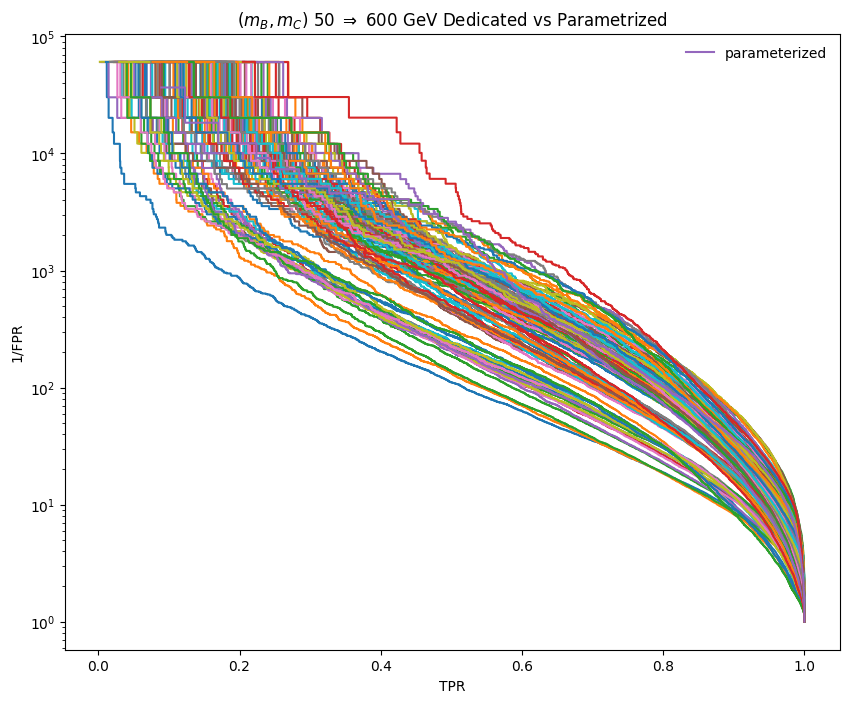

In [17]:
plt.figure(figsize=(10,8))
for i in range(len(tpr_mm_list)):
    plt.plot(tpr_mm_list[i], 1./fpr_mm_list[i])
plt.plot(tpr_all,1./fpr_all,label="parameterized")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{B},m_{C})$ 50 $\Rightarrow$ 600 GeV Dedicated vs Parametrized")

In [205]:
len(tuple_mass_index[(0.5, 0.5)][0])

17319

In [460]:
preds_all_50 = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[.5,.5],axis=1)==1],batch_size=1000)
fpr_all_50, tpr_all_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[.5,.5],axis=1)==1], preds_all_50)

preds_all_200 = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[2.,2.],axis=1)==1],batch_size=1000)
fpr_all_200, tpr_all_200, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[2.,2.],axis=1)==1], preds_all_200)

preds_all_400 = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[4.,4.],axis=1)==1],batch_size=1000)
fpr_all_400, tpr_all_400, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4.,4.],axis=1)==1], preds_all_400)

preds_all_600 = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[6.,6.],axis=1)==1],batch_size=1000)
fpr_all_600, tpr_all_600, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[6.,6.],axis=1)==1], preds_all_600)

87/87 [==============================] - 0s 622us/step


Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized')

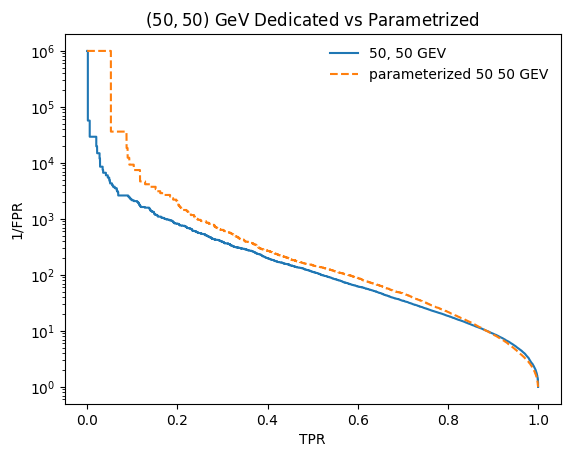

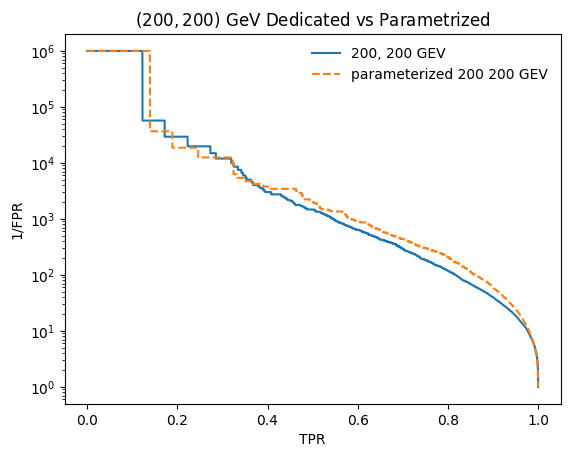

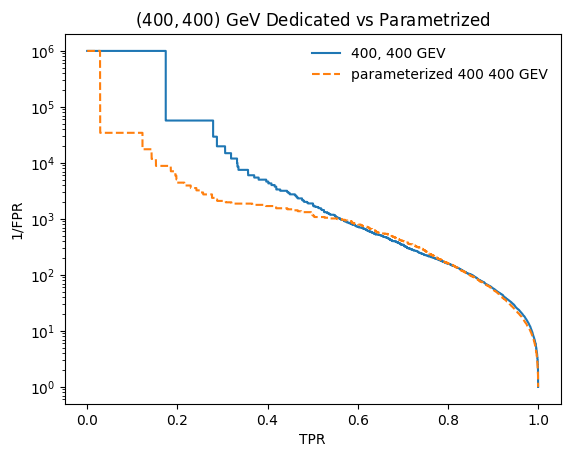

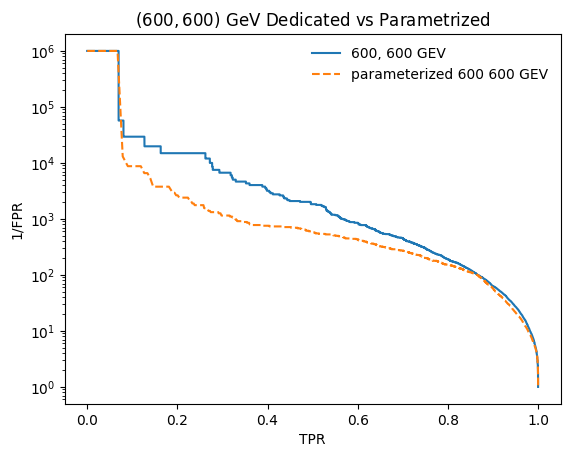

In [461]:
epsilon = 1e-6
plt.figure()
plt.plot(tpr_mm_list[0], 1./(fpr_mm_list[0] + epsilon), label = "50, 50 GEV")
plt.plot(tpr_all_50, 1./(fpr_all_50 + epsilon),label="parameterized 50 50 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(50,50)$ GeV Dedicated vs Parametrized")

plt.figure()
plt.plot(tpr_mm_list[26], 1./(fpr_mm_list[26] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_all_200, 1./(fpr_all_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(200, 200)$ GeV Dedicated vs Parametrized")

plt.figure()
plt.plot(tpr_mm_list[52], 1./(fpr_mm_list[52] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_all_400, 1./(fpr_all_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(400, 400)$ GeV Dedicated vs Parametrized")

plt.figure()
plt.plot(tpr_mm_list[78], 1./(fpr_mm_list[78] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_600, 1./(fpr_all_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized")

Text(0.5, 1.0, '$(m_{A},m_{B})$ GeV Dedicated vs Parametrized using MSE')

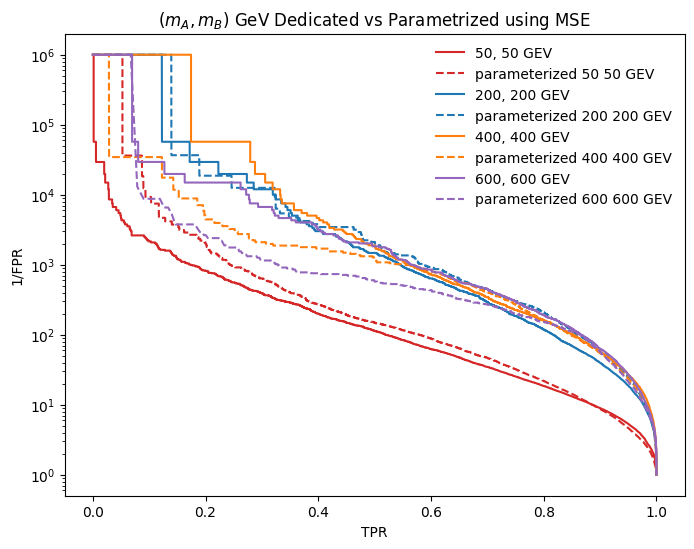

In [462]:
plt.figure(figsize = (8, 6))
epsilon = 1e-6
plt.plot(tpr_mm_list[0], 1./(fpr_mm_list[0] + epsilon), label = "50, 50 GEV", color = "#d62728")
plt.plot(tpr_all_50, 1./(fpr_all_50 + epsilon),label="parameterized 50 50 GEV", linestyle='dashed', color = "#d62728")

plt.plot(tpr_mm_list[26], 1./(fpr_mm_list[26] + epsilon), label = "200, 200 GEV", color = "#1f77b4")
plt.plot(tpr_all_200, 1./(fpr_all_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed', color = "#1f77b4")

plt.plot(tpr_mm_list[52], 1./(fpr_mm_list[52] + epsilon), label = "400, 400 GEV", color = "#ff7f0e")
plt.plot(tpr_all_400, 1./(fpr_all_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed', color = "#ff7f0e")

plt.plot(tpr_mm_list[78], 1./(fpr_mm_list[78] + epsilon), label = "600, 600 GEV", color = "#9467bd")
plt.plot(tpr_all_600, 1./(fpr_all_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed', color = "#9467bd")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{A},m_{B})$ GeV Dedicated vs Parametrized using MSE")

In [78]:
# plt.plot(tpr_mm_list[0],1./fpr_mm_list[0],label="dedicated_100")
# plt.plot(tpr_all_100,1./fpr_all_100,label="parameterized")
# plt.yscale("log")
# plt.legend(frameon=False)
# plt.xlabel("TPR")
# plt.ylabel("1/FPR")
# plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated vs Parametrized")

Text(0.5, 1.0, '$(m_{B},m_{C})$ GeV Dedicated vs Parametrized')

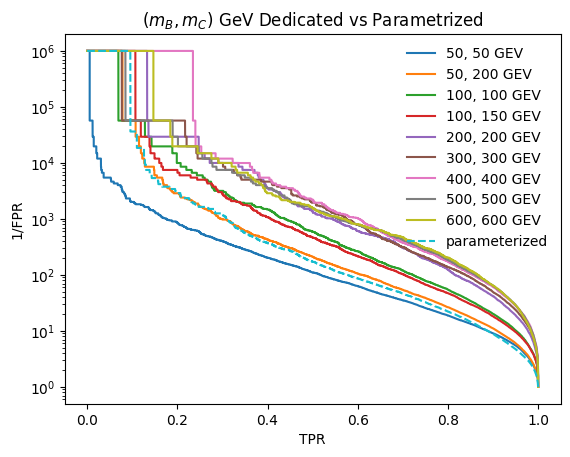

In [363]:
epsilon = 1e-6
plt.plot(tpr_mm_list[0], 1./(fpr_mm_list[0] + epsilon), label = "50, 50 GEV")
#plt.plot(tpr_mm_list[1], 1./(fpr_mm_list[1] + epsilon), label = "50, 100 GEV")
plt.plot(tpr_mm_list[3], 1./(fpr_mm_list[3] + epsilon), label = "50, 200 GEV")
plt.plot(tpr_mm_list[13], 1./(fpr_mm_list[13] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_mm_list[14], 1./(fpr_mm_list[14] + epsilon), label = "100, 150 GEV")
plt.plot(tpr_mm_list[26], 1./(fpr_mm_list[26] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_mm_list[39], 1./(fpr_mm_list[39] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_mm_list[52], 1./(fpr_mm_list[52] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_mm_list[65], 1./(fpr_mm_list[65] + epsilon), label = "500, 500 GEV")
plt.plot(tpr_mm_list[78], 1./(fpr_mm_list[78] + epsilon), label = "600, 600 GEV")

plt.plot(tpr_all, 1./(fpr_all + epsilon),label="parameterized", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{B},m_{C})$ GeV Dedicated vs Parametrized")

Analysis of Models begins here

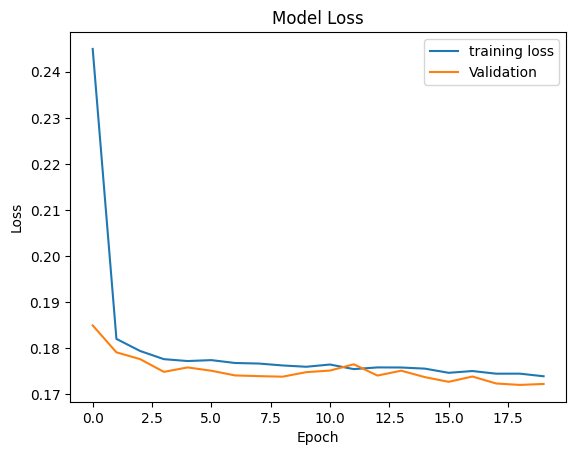

In [255]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [89]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = metrics.roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 737us/step


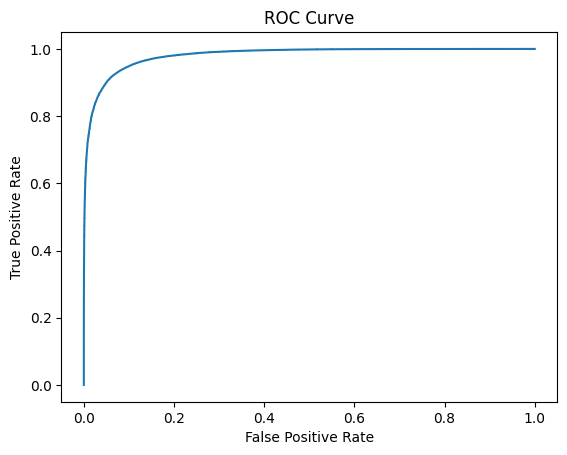

In [79]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [258]:
def pred_accuracy(y_test, predictions):

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

accuracy_model = pred_accuracy(Y_val_100, list(preds_100))
print("Accuracy of Model: {:.2%}".format(accuracy_model))

Accuracy of Model: 93.07%


In [33]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.ones(len(x_aug_0)),np.zeros(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.ones(len(x_aug_0)),np.zeros(len(x_aug_m))])

    np.save("x_vals_all",x_vals_all)
    np.save("y_vals_all",y_vals_all)

In [338]:
#x_aug_m

In [8]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [57]:
x_vals_all.shape

(27188652, 6)

In [58]:
x_vals_all

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319,  0.5       ,
         0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092,  0.5       ,
         0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752,  0.5       ,
         0.5       ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [9]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [10]:
Y_val_all

array([0., 0., 0., ..., 1., 0., 1.])

In [ ]:
model_all_BCE(X_train_all)

In [19]:
len(X_train_all)

13594326

In [433]:
#config2 = setup_wandb_parametrized();
class MyModel2(Model):
    def __init__(self):
        super(MyModel2, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation=config.activation_2)
        
        self.dense3 = Dense(config.layer_3, activation=config.activation_3)
        
        self.dense4 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        
        x = self.dense3(x)
        
        x = self.dense4(x)
        
        return x

In [439]:
wandb.init(
    project="Anomaly",
    group="Parametrized",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 1024,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 512,
        "activation_2": "relu",
        "layer_3": 256,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "MeanSquaredError",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 1024
    }
)

config = wandb.config

In [440]:
model_all = MyModel2()
model_all.build(input_shape=(None, X_train_all.shape[1]))
model_all.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=config2.optimizer, metrics=["accuracy"])
model_all.summary()

Model: "my_model2_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1435 (Dense)          multiple                  7168      
                                                                 
 dropout_191 (Dropout)       multiple                  0         
                                                                 
 dense_1436 (Dense)          multiple                  524800    
                                                                 
 dense_1437 (Dense)          multiple                  131328    
                                                                 
 dense_1438 (Dense)          multiple                  257       
                                                                 
Total params: 663,553
Trainable params: 663,553
Non-trainable params: 0
_________________________________________________________________


In [441]:
with tf.device('/gpu:0'):
    myhistory_all = model_all.fit(x_vals_all, y_vals_all, epochs=config2.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config2.batch_size*5, callbacks = [WandbCallback()])

Epoch 1/20
5292/5311 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.9308

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 15s 3ms/step - loss: 0.0519 - accuracy: 0.9308 - val_loss: 0.0477 - val_accuracy: 0.9361
Epoch 2/20
5304/5311 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9346

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 13s 2ms/step - loss: 0.0489 - accuracy: 0.9346 - val_loss: 0.0474 - val_accuracy: 0.9366
Epoch 3/20
5298/5311 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9351

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 13s 2ms/step - loss: 0.0485 - accuracy: 0.9351 - val_loss: 0.0473 - val_accuracy: 0.9366
Epoch 4/20
5288/5311 [============================>.] - ETA: 0s - loss: 0.0483 - accuracy: 0.9354

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 13s 2ms/step - loss: 0.0483 - accuracy: 0.9354 - val_loss: 0.0473 - val_accuracy: 0.9366
Epoch 5/20
5306/5311 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9356

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best)... Done. 0.2s


5311/5311 [==============================] - 13s 2ms/step - loss: 0.0481 - accuracy: 0.9356 - val_loss: 0.0472 - val_accuracy: 0.9367
Epoch 6/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.0480 - accuracy: 0.9357 - val_loss: 0.0472 - val_accuracy: 0.9367
Epoch 7/20
5300/5311 [============================>.] - ETA: 0s - loss: 0.0479 - accuracy: 0.9358

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 15s 3ms/step - loss: 0.0479 - accuracy: 0.9358 - val_loss: 0.0470 - val_accuracy: 0.9370
Epoch 8/20
5294/5311 [============================>.] - ETA: 0s - loss: 0.0479 - accuracy: 0.9359

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 13s 2ms/step - loss: 0.0479 - accuracy: 0.9359 - val_loss: 0.0469 - val_accuracy: 0.9371
Epoch 9/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.0478 - accuracy: 0.9360 - val_loss: 0.0472 - val_accuracy: 0.9368
Epoch 10/20
5311/5311 [==============================] - 13s 2ms/step - loss: 0.0478 - accuracy: 0.9360 - val_loss: 0.0471 - val_accuracy: 0.9368
Epoch 11/20
5311/5311 [==============================] - 13s 2ms/step - loss: 0.0477 - accuracy: 0.9361 - val_loss: 0.0470 - val_accuracy: 0.9370
Epoch 12/20
5287/5311 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9361

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 13s 2ms/step - loss: 0.0477 - accuracy: 0.9361 - val_loss: 0.0469 - val_accuracy: 0.9371
Epoch 13/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.0477 - accuracy: 0.9362 - val_loss: 0.0469 - val_accuracy: 0.9371
Epoch 14/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.0476 - accuracy: 0.9362 - val_loss: 0.0471 - val_accuracy: 0.9369
Epoch 15/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.0476 - accuracy: 0.9363 - val_loss: 0.0469 - val_accuracy: 0.9371
Epoch 16/20
5311/5311 [==============================] - 13s 2ms/step - loss: 0.0476 - accuracy: 0.9363 - val_loss: 0.0470 - val_accuracy: 0.9371
Epoch 17/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.0476 - accuracy: 0.9364 - val_loss: 0.0469 - val_accuracy: 0.9371
Epoch 18/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.0475 - accuracy: 0.9363 - val_loss: 0.0470 - val_accurac

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 13s 2ms/step - loss: 0.0475 - accuracy: 0.9363 - val_loss: 0.0468 - val_accuracy: 0.9372
Epoch 20/20
5306/5311 [============================>.] - ETA: 0s - loss: 0.0475 - accuracy: 0.9364

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_134604-22pcr8eo/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 13s 2ms/step - loss: 0.0475 - accuracy: 0.9364 - val_loss: 0.0468 - val_accuracy: 0.9373


In [442]:
wandb.finish()

accuracy,▁▆▆▇▇▇▇▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▄▄▄▆▇▅▅▆▇▇▆▇▇▇▆▇█
val_loss,█▆▅▅▄▄▃▂▄▄▃▂▂▃▂▂▂▃▁▁
accuracy,0.93636
best_epoch,19
best_val_loss,0.0468
epoch,19
loss,0.0475
val_accuracy,0.93727


In [443]:
#model_all.save("model_all_BCE")
model_all.save("model_all_MSE")

INFO:tensorflow:Assets written to: model_all_MSE/assets


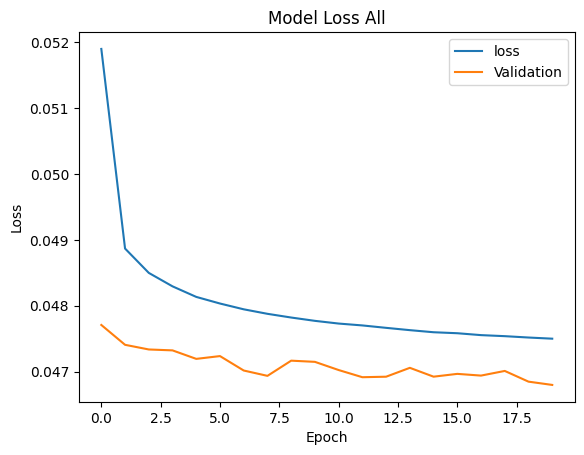

In [444]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [445]:
preds_all_MSE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_MSE, tpr_all_MSE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_MSE)

99/99 [==============================] - 0s 707us/step


In [119]:
preds_all_BCE = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE, tpr_all_BCE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE)

99/99 [==============================] - 0s 859us/step


In [452]:
model_BCE = tf.keras.models.load_model('model_BCE')
model_MSE = tf.keras.models.load_model('model_MSE')

In [454]:
preds_100_BCE = model_BCE.predict(X_val_100,batch_size=1000)
fpr_100_BCE, tpr_100_BCE, _ = metrics.roc_curve(Y_val_100, preds_100_BCE)

preds_100_MSE = model_MSE.predict(X_val_100,batch_size=1000)
fpr_100_MSE, tpr_100_MSE, _ = metrics.roc_curve(Y_val_100, preds_100_MSE)

99/99 [==============================] - 0s 729us/step


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE')

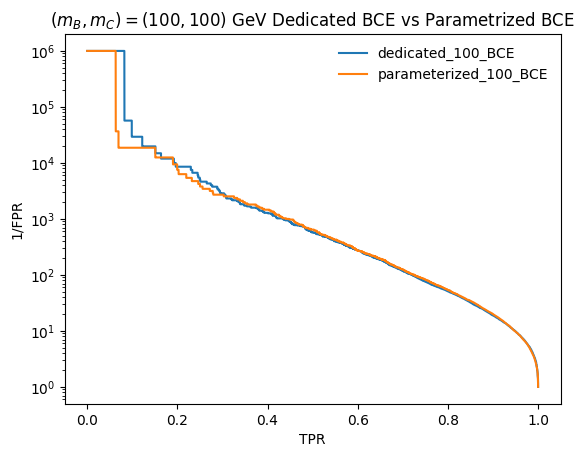

In [450]:
epsilon = 1e-6
plt.plot(tpr_100_BCE,1./(fpr_100_BCE + epsilon),label="dedicated_100_BCE")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE + epsilon),label="parameterized_100_BCE")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE")

Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated MSE vs Parametrized MSE')

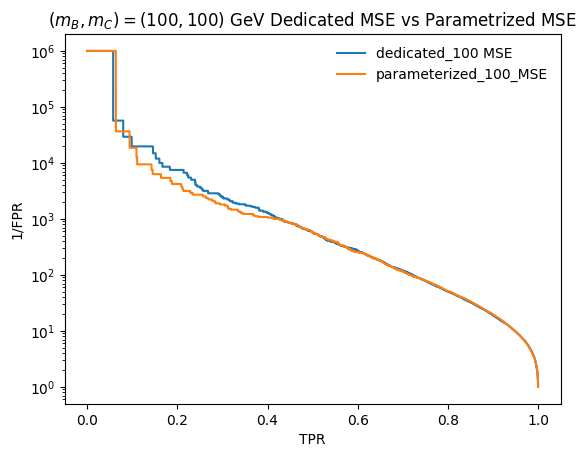

In [455]:
plt.plot(tpr_100_MSE,1./(fpr_100_MSE + epsilon),label="dedicated_100 MSE")
plt.plot(tpr_all_MSE,1./(fpr_all_MSE + epsilon),label="parameterized_100_MSE")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated MSE vs Parametrized MSE")

In [423]:
#freezes the layers of the model (i.e all trainable params)
for l in model_all.layers:
    l.trainable=False

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [82]:
model_all2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 tf.ones_like (TFOpLambda)      (None, 4)            0           ['input_3[0][0]']                
                                                                                                  
 tf.ones_like_1 (TFOpLambda)    (None, 4)            0           ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None,)             0           ['tf.ones_like[0][0]']           
 ingOpLambda)                                                                               

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [83]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 3.0335 - val_loss: 2.8581
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7964 - val_loss: 2.7314
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7099 - val_loss: 2.6704
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.6482 - val_loss: 2.6068
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5891 - val_loss: 2.5549
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5492 - val_loss: 2.5264
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5264 - val_loss: 2.5062
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5055 - val_loss: 2.4842
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4825 - val_loss: 2.4604
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4584 - val_loss: 2.4398

In [31]:
# class SingleWeightLayer(tf.keras.layers.Layer):
#     def __init__(self, initial_value=1, **kwargs):
#         super(SingleWeightLayer, self).__init__(**kwargs)
#         self.initial_value = initial_value
        
#     def build(self, input_shape):
#         self.weight = self.add_weight(shape=(1,), initializer=tf.keras.initializers.Constant(self.initial_value), trainable=True)
    
#     def call(self, inputs):            
#         output = inputs * self.weight
#         return tf.nn.relu(output)

In [491]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all_MSE.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(1.)
            model32 = createSimpleModel(4.)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all_MSE(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.ones(len(x[0,0])),np.zeros(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(x_vals_[:,0:4], y_vals_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

Epoch 1/10
192/192 [==============================] - 1s 3ms/step - loss: 0.2841 - val_loss: 0.2490
Epoch 2/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2520 - val_loss: 0.2442
Epoch 3/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2490 - val_loss: 0.2445
Epoch 4/10
192/192 [==============================] - 1s 4ms/step - loss: 0.2489 - val_loss: 0.2447
Epoch 5/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2489 - val_loss: 0.2448
Epoch 6/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2488 - val_loss: 0.2447
Epoch 7/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2487 - val_loss: 0.2448
Epoch 8/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2489 - val_loss: 0.2448
Epoch 9/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2487 - val_loss: 0.2448
Epoch 10/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2489 - val_loss: 0.2447

In [493]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [0.5150719 6.9897366]
[0.5 1. ] [1.0108448 7.5424237]
[0.5 1.5] [1.5104847 8.717662 ]
[1.  0.5] [1.0190138 7.5747533]
[1. 1.] [1.0259367 7.648488 ]
[1.  1.5] [1.2012172 8.563908 ]
[1.5 0.5] [1.5053748 8.770738 ]
[1.5 1. ] [1.1898474 8.512781 ]
[1.5 1.5] [1.5012769 8.60016  ]
found both: 0.9375
found one: 0.05555555555555555
found none: 0.006944444444444444


In [467]:
#load models
#import models
#model_all_BCE = tf.keras.models.load_model("model_all_BCE")
model_all_MSE = tf.keras.models.load_model("model_all_MSE")

In [469]:
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation="relu",
                         kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

In [21]:
#model_all_BCE(X_train_all[:100,:])

Signal Fraction:  0.001
Epoch 1/20
30/30 [==============================] - 1s 8ms/step - loss: 0.4359 - val_loss: 0.4374
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4352 - val_loss: 0.4363
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4339 - val_loss: 0.4352
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4326 - val_loss: 0.4341
Epoch 5/20
30/30 [==============================] - 0s 4ms/step - loss: 0.4314 - val_loss: 0.4330
Epoch 6/20
30/30 [==============================] - 0s 4ms/step - loss: 0.4301 - val_loss: 0.4318
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4288 - val_loss: 0.4307
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4275 - val_loss: 0.4294
Epoch 9/20
30/30 [==============================] - 0s 4ms/step - loss: 0.4263 - val_loss: 0.4282
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4249 - val_loss: 0.

KeyboardInterrupt: 

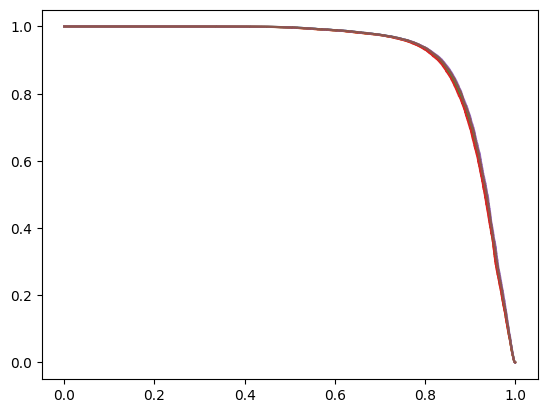

In [672]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []

epsilon = 1e-6
sig_space = np.logspace(-3,-1, 20)
for sigfrac in sig_space:
    #sigfrac = 0.25
    print("Signal Fraction: ", sigfrac)
    for l in model_all_MSE.layers:
        l.trainable=False

    model3 = createSimpleModel(3)
    model32 = createSimpleModel(5)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_MSE(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    #LLR_xs = 1. + sigfrac*LLR - sigfrac
    LLR_xs = 1.+ model33(tf.ones_like(inputs)[:,0])*LLR - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))

    m1 = 3.5
    m2 = 4.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.ones(train_reference),np.zeros(train_data + 1),np.zeros(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2, model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    #w3 = model_all2.trainable_weights[2].numpy()[0][0]
    #w3_list+=[np.exp(w3)]
    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.ones(train_background),np.zeros(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    max_SIC1+=[np.max(tpr/np.sqrt(fpr+ epsilon))]
    
    plt.plot(tpr,1-fpr + epsilon)
    roc_auc = metrics.auc(fpr, tpr)
    print("AUC: ",roc_auc)
    
#     plt.plot(tpr,tpr/np.sqrt(fpr))

In [624]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

(0.0, 700.0)

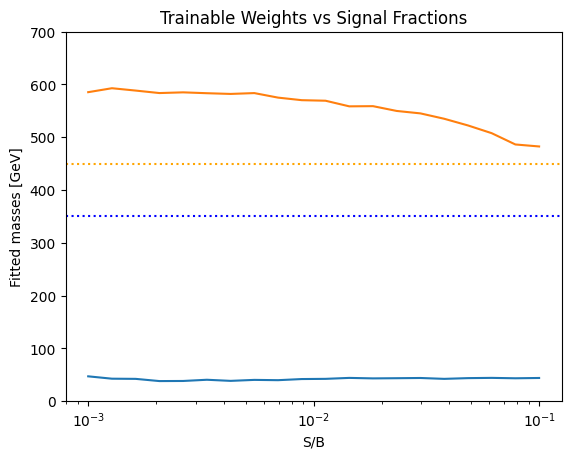

In [625]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

In [464]:
# plt.plot(sig_list,np.array(w3_list))
# plt.xscale("log")
# plt.yscale("log")
# plt.plot(sig_list,sig_list,ls=":",color="black")
# plt.xlabel("S/B")
# plt.ylabel("Fitted S/B")

In [236]:
plt.plot(sig_list,max_SIC1,label="Semi Weakly")
#plt.plot(sig_list,max_SIC2,label="Weakly (CWOLA)")
plt.legend(frameon = False)
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")
plt.title("Significance Improvement vs S/B")
#plt.axhline(450,ls=":",color='orange')
#plt.axhline(200,ls=":",color='blue')
#plt.ylim([0,2])

In [ ]:
sig_list = []
w1_list = []
w2_list = []
#w3_list = []
ww = []

max_SIC1 = []
max_SIC2 = []

sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    #sigfrac = .05
    print("Signal Fraction: ", sigfrac)
    for l in model_all_MSE.layers:
        l.trainable=False

    model3 = createSimpleModel(3)
    model32 = createSimpleModel(5)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_MSE(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1.+sigfrac*LLR - sigfrac
    #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))

    m1 = 2.5
    m2 = 5.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.ones(train_reference),np.zeros(train_data + 1),np.zeros(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    # w1 = model_all2.trainable_weights[0].numpy()[0][0]
    # w2 = model_all2.trainable_weights[1].numpy()[0][0]
    # ww += [np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    #sig_list+=[sigfrac]
    # w1_list+=[w1]
    # w2_list+=[w2]
    #w3_list+=[np.exp(w3)]
    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.ones(train_background),np.zeros(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.ones(test_background),np.zeros(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    # plt.plot(tpr2,tpr2/np.sqrt(fpr2))
    
    max_SIC1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
    # max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]

Signal Fraction:  0.001
Epoch 1/20
30/30 [==============================] - 1s 8ms/step - loss: 0.2991 - val_loss: 0.3012
Epoch 2/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2983 - val_loss: 0.3003
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2976 - val_loss: 0.2994
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2965 - val_loss: 0.2985
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2959 - val_loss: 0.2976
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2950 - val_loss: 0.2968
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2943 - val_loss: 0.2960
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2934 - val_loss: 0.2951
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2924 - val_loss: 0.2943
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2921 - val_loss: 0

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 8ms/step - loss: 0.3046 - val_loss: 0.3043
Epoch 2/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3040 - val_loss: 0.3034
Epoch 3/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3031 - val_loss: 0.3024
Epoch 4/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3025 - val_loss: 0.3016
Epoch 5/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3012 - val_loss: 0.3006
Epoch 6/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3007 - val_loss: 0.2997
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2992 - val_loss: 0.2988
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2986 - val_loss: 0.2979
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2983 - val_loss: 0.2971
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2975 - val_loss: 0.2962
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 15ms/step - loss: 0.3093 - val_loss: 0.3086
Epoch 2/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3086 - val_loss: 0.3077
Epoch 3/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3075 - val_loss: 0.3067
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3062 - val_loss: 0.3058
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3055 - val_loss: 0.3049
Epoch 6/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3054 - val_loss: 0.3040
Epoch 7/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3037 - val_loss: 0.3031
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3029 - val_loss: 0.3022
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3023 - val_loss: 0.3013
Epoch 10/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3016 - val_loss: 0.3004
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 8ms/step - loss: 0.3128 - val_loss: 0.3143
Epoch 2/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3120 - val_loss: 0.3133
Epoch 3/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3108 - val_loss: 0.3124
Epoch 4/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3101 - val_loss: 0.3114
Epoch 5/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3091 - val_loss: 0.3104
Epoch 6/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3084 - val_loss: 0.3095
Epoch 7/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3078 - val_loss: 0.3085
Epoch 8/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3065 - val_loss: 0.3076
Epoch 9/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3057 - val_loss: 0.3066
Epoch 10/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3051 - val_loss: 0.3057
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 6s 187ms/step - loss: 0.3199 - val_loss: 0.3170
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3188 - val_loss: 0.3160
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3172 - val_loss: 0.3150
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3166 - val_loss: 0.3140
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3159 - val_loss: 0.3131
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3148 - val_loss: 0.3122
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3142 - val_loss: 0.3113
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3131 - val_loss: 0.3103
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3125 - val_loss: 0.3093
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3114 - val_loss: 0.3084
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.3218 - val_loss: 0.3244
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3210 - val_loss: 0.3234
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3199 - val_loss: 0.3224
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3191 - val_loss: 0.3214
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3185 - val_loss: 0.3203
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3174 - val_loss: 0.3194
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3163 - val_loss: 0.3184
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3157 - val_loss: 0.3175
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3144 - val_loss: 0.3165
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3136 - val_loss: 0.3154
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.3283 - val_loss: 0.3275
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3277 - val_loss: 0.3265
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3268 - val_loss: 0.3255
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3255 - val_loss: 0.3244
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3250 - val_loss: 0.3234
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3239 - val_loss: 0.3224
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3229 - val_loss: 0.3214
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3224 - val_loss: 0.3205
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3206 - val_loss: 0.3194
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3204 - val_loss: 0.3184
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.3341 - val_loss: 0.3317
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3339 - val_loss: 0.3307
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3322 - val_loss: 0.3298
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3316 - val_loss: 0.3288
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3303 - val_loss: 0.3278
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3297 - val_loss: 0.3268
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3282 - val_loss: 0.3259
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3276 - val_loss: 0.3248
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3267 - val_loss: 0.3239
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3254 - val_loss: 0.3229
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.3393 - val_loss: 0.3367
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3378 - val_loss: 0.3358
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3373 - val_loss: 0.3348
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3360 - val_loss: 0.3339
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3353 - val_loss: 0.3329
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3343 - val_loss: 0.3319
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3327 - val_loss: 0.3310
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3322 - val_loss: 0.3300
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3315 - val_loss: 0.3290
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3300 - val_loss: 0.3280
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.3447 - val_loss: 0.3413
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3436 - val_loss: 0.3404
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3425 - val_loss: 0.3394
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3417 - val_loss: 0.3385
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.3409 - val_loss: 0.3376
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3397 - val_loss: 0.3366
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3390 - val_loss: 0.3357
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3379 - val_loss: 0.3347
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3369 - val_loss: 0.3338
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3364 - val_loss: 0.3328
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.3481 - val_loss: 0.3482
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3475 - val_loss: 0.3472
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3462 - val_loss: 0.3462
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3455 - val_loss: 0.3452
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3450 - val_loss: 0.3442
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3434 - val_loss: 0.3432
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3425 - val_loss: 0.3422
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3421 - val_loss: 0.3411
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3413 - val_loss: 0.3402
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3397 - val_loss: 0.3392
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.3540 - val_loss: 0.3528
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3526 - val_loss: 0.3519
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3523 - val_loss: 0.3509
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3512 - val_loss: 0.3500
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3502 - val_loss: 0.3490
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3495 - val_loss: 0.3481
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3483 - val_loss: 0.3472
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3471 - val_loss: 0.3462
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3461 - val_loss: 0.3453
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3453 - val_loss: 0.3444
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.3617 - val_loss: 0.3554
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3607 - val_loss: 0.3545
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3599 - val_loss: 0.3535
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3591 - val_loss: 0.3527
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3581 - val_loss: 0.3518
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3570 - val_loss: 0.3508
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3563 - val_loss: 0.3499
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3552 - val_loss: 0.3489
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3544 - val_loss: 0.3480
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3536 - val_loss: 0.3471
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 24ms/step - loss: 0.3631 - val_loss: 0.3649
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3625 - val_loss: 0.3640
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3618 - val_loss: 0.3631
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3607 - val_loss: 0.3620
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3596 - val_loss: 0.3611
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3586 - val_loss: 0.3601
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3577 - val_loss: 0.3591
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3566 - val_loss: 0.3582
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3562 - val_loss: 0.3573
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3549 - val_loss: 0.3563
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.3685 - val_loss: 0.3709
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3674 - val_loss: 0.3699
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3662 - val_loss: 0.3689
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3652 - val_loss: 0.3680
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3647 - val_loss: 0.3671
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3635 - val_loss: 0.3662
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3630 - val_loss: 0.3653
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3622 - val_loss: 0.3643
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3610 - val_loss: 0.3634
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3605 - val_loss: 0.3625
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 9ms/step - loss: 0.3745 - val_loss: 0.3754
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3737 - val_loss: 0.3744
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3730 - val_loss: 0.3734
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3718 - val_loss: 0.3725
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3712 - val_loss: 0.3715
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3703 - val_loss: 0.3706
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3695 - val_loss: 0.3697
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3682 - val_loss: 0.3688
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3675 - val_loss: 0.3679
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3664 - val_loss: 0.3670
Epoch 11/20
31/31 [===========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 9ms/step - loss: 0.3797 - val_loss: 0.3811
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3792 - val_loss: 0.3802
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3785 - val_loss: 0.3793
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3773 - val_loss: 0.3784
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3763 - val_loss: 0.3775
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3755 - val_loss: 0.3766
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3748 - val_loss: 0.3758
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3737 - val_loss: 0.3749
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3730 - val_loss: 0.3740
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3718 - val_loss: 0.3732
Epoch 11/20
31/31 [===========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 9ms/step - loss: 0.3862 - val_loss: 0.3861
Epoch 2/20
31/31 [==============================] - 1s 18ms/step - loss: 0.3854 - val_loss: 0.3852
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3844 - val_loss: 0.3843
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3837 - val_loss: 0.3834
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3826 - val_loss: 0.3826
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3819 - val_loss: 0.3817
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3810 - val_loss: 0.3808
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3800 - val_loss: 0.3799
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3792 - val_loss: 0.3791
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3784 - val_loss: 0.3782
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 9ms/step - loss: 0.3935 - val_loss: 0.3899
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3922 - val_loss: 0.3890
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3918 - val_loss: 0.3882
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3907 - val_loss: 0.3873
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3897 - val_loss: 0.3865
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3890 - val_loss: 0.3857
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3885 - val_loss: 0.3849
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3872 - val_loss: 0.3842
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3865 - val_loss: 0.3834
Epoch 10/20
31/31 [==============================] - 1s 19ms/step - loss: 0.3854 - val_loss: 0.3826
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/917175645.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 8ms/step - loss: 0.3955 - val_loss: 0.3979
Epoch 2/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3942 - val_loss: 0.3970
Epoch 3/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3934 - val_loss: 0.3962
Epoch 4/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3927 - val_loss: 0.3954
Epoch 5/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3920 - val_loss: 0.3946
Epoch 6/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3912 - val_loss: 0.3939
Epoch 7/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3905 - val_loss: 0.3931
Epoch 8/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3896 - val_loss: 0.3924
Epoch 9/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3888 - val_loss: 0.3916
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3881 - val_loss: 0.3909
Epoch 11/20
 1/31 [...........

model_all2.trainable_

In [ ]:
sig_list

In [ ]:
len(signal)

(0.0, 700.0)

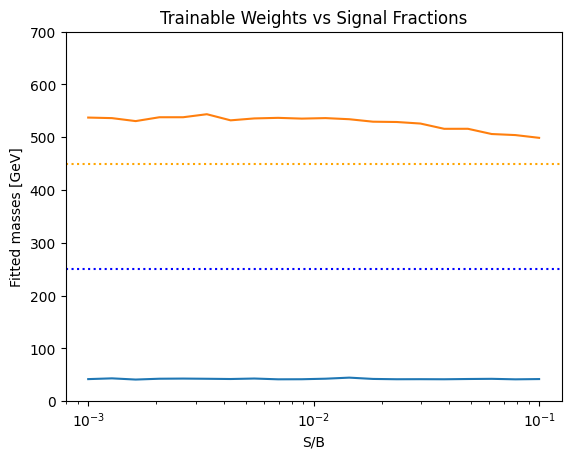

In [670]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

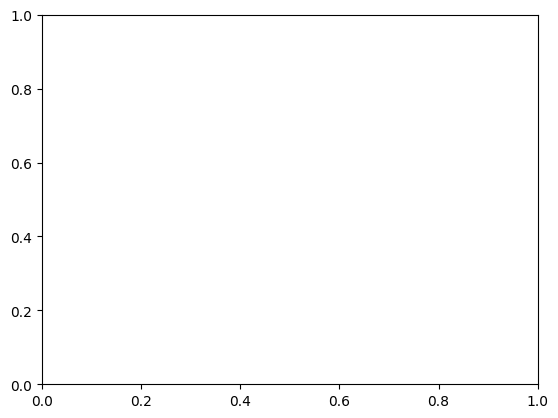

In [666]:
plt.plot(sig_list,np.array(ww))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")

Text(0, 0.5, 'max SIC')

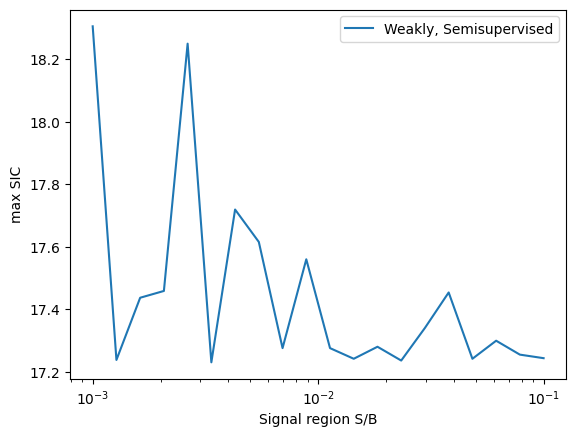

In [595]:
plt.plot(sig_list,max_SIC1,label="Weakly, Semisupervised")
#plt.plot(sig_list,max_SIC2,label="Weakly Supervised")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

In [555]:
# def check_gradients(model, data):
#     with tf.GradientTape() as tape:
#         predictions = model_all2(data)
#         loss = tf.reduce_mean(loss_object(y_true, predictions))
#     gradients = tape.gradient(loss, model.trainable_variables)

#     for grad, var in zip(gradients, model.trainable_variables):
#         if grad is not None:
#             # Perform checks or logging as needed
#             print(f"Gradient for {var.name}: {tf.reduce_mean(grad).numpy()}")
#         else:
#             print(f"No gradient for {var.name}")

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     for batch in data_loader:
#         check_gradients(model_all2, batch)
#         model_all2.fit(batch)

# check_gradients(model_all2, batch)

In [661]:
xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []

epsilon = 1e-6
for sigfrac in np.logspace(-3,-1,20):
    print(sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(2.))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(3.))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)
    
    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1.+sigfrac*LLR
    #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR - model33(tf.ones_like(inputs)[:,0])
    backtoprob = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = backtoprob)
    model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.004))

    m1 = 2
    m2 = 4.5

    test_set_back = int(len(x[0,0])*0.5)
    train_set_reference = int(len(x[0,0])*0.25)
    train_set_data = len(x[0,0]) - test_set_back - train_set_reference
    test_set_sig = int(len(x[m1,m2])*0.5)
    sig_frac = sigfrac

    #tot = test_set_back
    x_vals_ = np.concatenate([x[0,0][test_set_back:],x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*train_set_reference)]])
    y_vals_ = np.concatenate([np.ones(train_set_reference),np.zeros(train_set_data),np.zeros(len(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*train_set_reference)]))])

    print(tot,len(x[0,0])-tot,len(x[m1,m2][0:int(sig_frac*tot)]),len(x[m1,m2][0:int(sig_frac*tot)])/tot)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
    
    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=40,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y = np.concatenate([np.ones(test_set_back),np.zeros(test_set_sig)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)

0.001
60465 60465 60 0.0009923096005953857
Epoch 1/40
30/30 [==============================] - 1s 7ms/step - loss: 0.2827 - val_loss: 0.2832
Epoch 2/40
30/30 [==============================] - 0s 4ms/step - loss: 0.2791 - val_loss: 0.2794
Epoch 3/40
30/30 [==============================] - 1s 19ms/step - loss: 0.2764 - val_loss: 0.2759
Epoch 4/40
30/30 [==============================] - 0s 4ms/step - loss: 0.2725 - val_loss: 0.2729
Epoch 5/40
30/30 [==============================] - 0s 5ms/step - loss: 0.2702 - val_loss: 0.2703
Epoch 6/40
30/30 [==============================] - 0s 4ms/step - loss: 0.2677 - val_loss: 0.2680
Epoch 7/40
30/30 [==============================] - 0s 5ms/step - loss: 0.2660 - val_loss: 0.2659
Epoch 8/40
30/30 [==============================] - 0s 5ms/step - loss: 0.2639 - val_loss: 0.2641
Epoch 9/40
30/30 [==============================] - 0s 4ms/step - loss: 0.2625 - val_loss: 0.2624
Epoch 10/40
30/30 [==============================] - 0s 5ms/step - loss: 0

(0.0, 600.0)

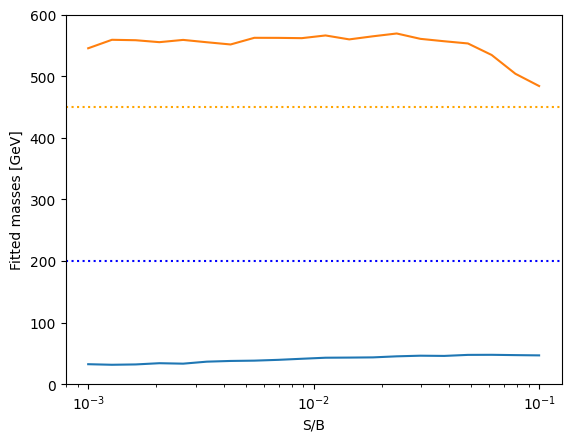

In [662]:
plt.plot(xx,np.array(yy)*100)
plt.plot(xx,np.array(zz)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
plt.ylim([0,600])